In [1]:
#As always, we import everything
import pandas as pd
import os
import re
import hdf5_getters as getters
import requests
from bs4 import BeautifulSoup
import numpy as np
from collections import OrderedDict
from tqdm import tqdm

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords as stop_words
from textblob import Word
import pycountry
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from gensim import corpora, models
import matplotlib
import json

import warnings
warnings.filterwarnings('ignore')

# Introduction

Our project consists of exploring the lyrics of many songs and finding themes and the usage of the words used in these songs over time. We use the Million Song dataset to find information about the song as well as various other datasets and sources to find lyrics data.

# Data Collection and Descriptive Analysis

We begin by getting a list of all the files from our dataset. The Million Song dataset organises the dataset in multiple files and directories. The following code snippet gets all these files and prints the number of the files found.

In [2]:
data_dir = './' + 'data'

In [3]:
# all_files contain all the files in the Million song subset downloaded (10000 datapoints)
all_files = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(data_dir + "/MillionSongSubset/data")):
    all_files.extend([dirpath + "/" + filename for filename in filenames if filename.endswith(".h5")])
all_files_num = len(all_files)
all_files_num

0

Some helpful methods to get information from million song dataset

In [4]:
def get_num_songs(filename):
    """
    Wrapper around getter method provided with the dataset.
    """
    h5 = getters.open_h5_file_read(filename)
    track_id = getters.get_num_songs(h5)
    h5.close()
    return track_id

In [5]:
def get_track_id(filename):
    """
    Wrapper around getter method provided with the dataset.
    """
    h5 = getters.open_h5_file_read(filename)
    track_id = getters.get_track_id(h5)
    h5.close()
    return track_id

In [6]:
def get_title(filename):
    """
    Wrapper around getter method provided with the dataset.
    """
    h5 = getters.open_h5_file_read(filename)
    title = getters.get_title(h5).decode()
    h5.close()
    return title

In [7]:
def get_artist_name(filename):
    """
    Wrapper around getter method provided with the dataset.
    """
    h5 = getters.open_h5_file_read(filename)
    artist_name = getters.get_artist_name(h5).decode()
    h5.close()
    return artist_name

In [8]:
def get_year(filename):
    """
    Wrapper around getter method provided with the dataset.
    """
    h5 = getters.open_h5_file_read(filename)
    year = getters.get_year(h5)
    h5.close()
    return year

Using an additional dataset obtained from the million song website that contains genre information, create genre_dataset. This dataset contains genre information for 191401 songs. 

In [9]:
'''

# Create genre dataframe
genre_dataset = pd.read_table(os.path.join(data_dir, 'tagtraum_genre_annotations/genre_dataset.txt'),
                              delimiter ='\t', names=('track_id', 'genre'), index_col = 'track_id')


# remove first row 
genre_dataset = genre_dataset.iloc[1:]
# remove comma
genre_dataset['genre'] = genre_dataset['genre'].str[:-1]

print(genre_dataset.shape)
genre_dataset.head()

# Another helpful dataset obtained from the website of million song dataset is one that contains year the track was released. In addition to year, it also contains track_id, the name of the artist, and title of the track. This dataset contains 515576 data points. 

# Create year dataframe 
year_dataset = pd.read_table(os.path.join(data_dir, 'tracks_per_year.txt'),delimiter ='<SEP>',
                             names=('year','track_id', 'artist_name','title'), index_col = 'track_id')

print(year_dataset.shape)
year_dataset.head()

year_artist_name_title_genre = pd.merge(year_dataset, genre_dataset, left_index=True, right_index=True)
year_artist_name_title_genre[['artist_name','title']] = year_artist_name_title_genre[['artist_name','title']].apply(lambda x: x.str.lower())

print(year_artist_name_title_genre.shape)
year_artist_name_title_genre.head()

year_artist_name_title_genre.year.unique()

year_artist_name_title_genre.genre.unique()

# End of Genre/ Year Intersection. Number of Data points available: 152793

# The next two cells takes about 5min to run. It takes all the .h5 files from million songs dataset and extracts the track_id, title and artist_name. It then puts all of it into a dataframe. 

Merge with 
lo_track_id = []
lo_title = []
lo_artist_name = []
for file_name in all_files:
    track_id = get_track_id(file_name)
    lo_track_id.append(track_id.decode("utf-8"))
    title = get_title(file_name)
    lo_title.append(title.lower())
    artist_name = get_artist_name(file_name)
    lo_artist_name.append(artist_name.lower())

million_song = pd.DataFrame(
    {'track_id': lo_track_id,
     'artist_name': lo_artist_name,
     'title': lo_title
    })
'''

'\n\n# Create genre dataframe\ngenre_dataset = pd.read_table(os.path.join(data_dir, \'tagtraum_genre_annotations/genre_dataset.txt\'),\n                              delimiter =\'\t\', names=(\'track_id\', \'genre\'), index_col = \'track_id\')\n\n\n# remove first row \ngenre_dataset = genre_dataset.iloc[1:]\n# remove comma\ngenre_dataset[\'genre\'] = genre_dataset[\'genre\'].str[:-1]\n\nprint(genre_dataset.shape)\ngenre_dataset.head()\n\n# Another helpful dataset obtained from the website of million song dataset is one that contains year the track was released. In addition to year, it also contains track_id, the name of the artist, and title of the track. This dataset contains 515576 data points. \n\n# Create year dataframe \nyear_dataset = pd.read_table(os.path.join(data_dir, \'tracks_per_year.txt\'),delimiter =\'<SEP>\',\n                             names=(\'year\',\'track_id\', \'artist_name\',\'title\'), index_col = \'track_id\')\n\nprint(year_dataset.shape)\nyear_dataset.head()\n

In [10]:
# Saving to csv

# year_artist_name_title_genre.to_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv"), encoding='utf-8')

# Loading

year_artist_name_title_genre = pd.read_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv")).set_index('track_id')
year_artist_name_title_genre.head()

,year,artist_name,title,genre
track_id,,,,
TRSGHLU128F421DF83,1922,alberta hunter,don't pan me,Blues
TRRAHXQ128F42511FF,1922,barrington levy,looking my love,Reggae
TRFAFTK12903CC77B8,1922,barrington levy,warm and sunny day,Reggae
TRTRKSF12903CFEDD7,1924,vernon dalhart,wreck of the old 97,Country
TRQYSYF128F935F350,1925,bessie smith,careless love blues,Blues


# Descriptive Analysis

In [56]:
year_artist_name_title_genre['genre'].value_counts()

Rock          62344
Electronic    18043
Pop           11058
Jazz          10662
Rap            8156
Metal          8035
RnB            7692
Country        6652
Reggae         5475
Blues          4228
Folk           3484
Punk           2739
Latin          1954
World          1384
New Age         887
Name: genre, dtype: int64

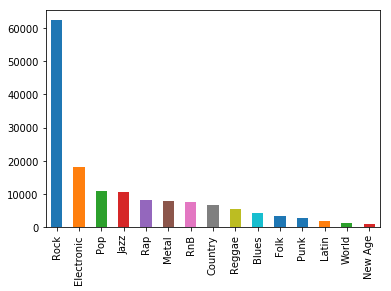

In [55]:
# Value count by Genre 
value_count_by_genre = year_artist_name_title_genre['genre'].value_counts().plot(kind = 'bar')
value_count_by_genre


2000    87300
1990    36693
1980    13201
1970     8340
1960     3580
2010     2399
1950      944
1940      138
1930      111
1920       87
Name: decade, dtype: int64


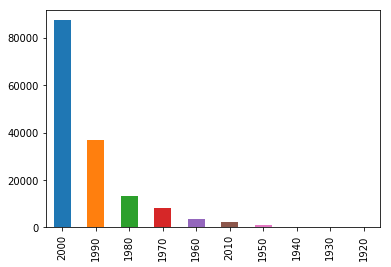

In [58]:
# value 
year_artist_name_title_genre['decade'] = (year_artist_name_title_genre['year'] // 10) * 10
#year_artist_name_title_genre = year_artist_name_title_genre.sort_index(axis = 1)
value_count_by_year = year_artist_name_title_genre['decade'].value_counts().plot(kind = 'bar')

print(year_artist_name_title_genre['decade'].value_counts())
value_count_by_year

# Arthur's code here

In [39]:
import re
import lyricfetcher

def scrape_lyrics(artists_list,songs_list):
    '''
    
    '''
    lyrics_not_found = []
    if (len(artists_list) == 0 or len(songs_list) == 0):
        raise ListError('The provided artists list or songs list is empty')
        
    elif (len(artists_list) != len(songs_list)):
        raise ListError('The provided artists and songs lists have different lenghts')
        
    else:
        lyrics = []
        
        for i in range(len(artists_list)):
            try:
                lyrics_metro = str(lyricfetcher.get_lyrics('metrolyrics',artists_list[i],songs_list[i]))
                lyrics_metro = re.sub(r'[\[].*?[\]]', '', lyrics_metro.replace('\n', ' '))
                lyrics_metro = re.sub(',', '', lyrics_metro)

                if (lyrics_metro == "" or len(lyrics_metro.split())<3):
                    lyrics_az = str(lyricfetcher.get_lyrics('azlyrics',artists_list[i],songs_list[i]))
                    lyrics_az = re.sub(r'[\[].*?[\]]', '', lyrics_az.replace('\n', ' '))
                    lyrics_az = re.sub(',', '', lyrics_az)

                    if (lyrics_az == "" or len(lyrics_az.split())<3):
                        lyrics.append("")
                        raise ValueError('No lyrics OR lyrics smaller or equal to 2 words found')

                    else:
                        lyrics.append(lyrics_az)

                else:
                    lyrics.append(lyrics_metro)
                    
            except ValueError:
                lyrics_not_found.append([artists_list[i],songs_list[i]])
                continue
    return lyrics, lyrics_not_found

In [40]:
# Test on subset

lyrics, lyrics_not_found_list = scrape_lyrics(year_artist_name_title_genre['artist_name'].tail(20),year_artist_name_title_genre['title'].tail(20))

print(lyrics)
print(lyrics_not_found_list)
print('Count of not found lyrics : ' + str(len(lyrics_not_found_list)))

import csv

with open(os.path.join(data_dir + "/lyrics.csv"), "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerows([year_artist_name_title_genre.index.values.tolist(),lyrics])

['', '', '', '', "What is she covering up? What is she lying about? She's hesitating... And she's using slow words I know But she's moving fast. Why is this happening now Why does this happen to me - all the time? Don't give up on me (Love) And I won't give up on you. (Love) Squeeze me 'til I can't breathe. And lets just lie here In oblivion. I can't believe in one of us I can't know - how long This love will last. Stay up in bed with me Stay up and play with me All day long. Don't give up on me (Love) And I won't give up on you. (Love) I get to wait for the baby (Love me girl) Nothing is wrong what are you scared of? Squeeze me 'til I can't breathe. And lets just lie here In oblivion. I can't believe in one of us I can't know - how long This love will last. Stay up in bed with me Stay up and play with me All day long. Don't give up on me (Love) And I won't give up on you (Love) I get to wait for the baby (Love me girl) Love me girl.", "Too much too much is never enough I had you and I


[['xenia beliayeva', 'analog effekt'], ['year long disaster', 'stranger in my room'], ['year long disaster', 'she told us all'], ['year long disaster', 'cyclone'], ['zpu', 'revoluciã³n'], ['the bird and the bee', 'maneater'], ['the bird and the bee', 'private eyes']]
Count of not found lyrics : 7


This function links gets the genres for a single track given its id.

In [ ]:
def get_song_genres(track_id):
    """
    Get's the genres of a song given it's ID in a single string, separated by &.
    """
    if track_id in genre_dataset.index:
        return "&".join(genre_dataset.loc[[track_id]].values[0][0].split(' and '))
    else:
        return None

Before starting our data collection, we make sure that all files correspond to only one song as they should.

In [ ]:
for filename in tqdm(all_files): # tqdm for a nice progress bar
    assert get_num_songs(filename) == 1 # check whether each file correctly corresponds to a single song.

The following snippet reads the Million Song dataset in its entirety and uses the genre dataset to link the two. It gets all the fields we need as we discussed above and also gets the genres of each track. This information is then put into a dataframe. 

For convenience, we save this data in a new `.csv` file.

In [ ]:
# The dataframe is saved into a file for convenience.
"""
data = pd.DataFrame([])

for filename in tqdm(all_files):
    track_id = get_track_id(filename).decode()
    genres = get_song_genres(track_id)
    if genres:
        to_add = [('track_id', track_id), ('genres', genres), ('artist_name', get_artist_name(filename)), ('title', get_title(filename)), ('year', get_year(filename)), ('lyrics', "")]
        data = data.append(pd.DataFrame(OrderedDict(to_add), index=[0]))

data.set_index('track_id', inplace=True)
data.to_csv('data/data.csv')
"""

data = pd.read_csv('data/data.csv').set_index('track_id')

Finally, we need to obtain lyrics data for our tracks. For this, we have found two datasets. Both of these contain artist, track title and lyrics data which we read in the following code snippets. We try to get the lyrics from both datasets, but it's possible that neither of them contains the lyrics for some on our tracks. For this reason, we will also look at genius.com which is a website containing many lyrics.

In [ ]:
lyrics_df1 = pd.read_csv('lyrics/songdata1.csv')
lyrics_df1.set_index(['artist', 'song'], inplace=True)

In [ ]:
lyrics_df2_raw = pd.read_csv('lyrics/songdata2.csv', na_filter=False)
lyrics_df2 = lyrics_df2_raw[['song', 'artist', 'lyrics']].set_index(['artist', 'song'])

In [ ]:
def get_lyrics_csv1(artist_name, title):
    """
    Gets lyrics for an artist and title pair from the first dataset.
    """
    if (artist_name, title) in lyrics_df1.index:
        return lyrics_df1.loc[artist_name, title].values[0][1]
    else:
        return None

In [ ]:
def get_lyrics_csv2(artist_name, title):
    """
    Gets lyrics for an artist and title pair from the second dataset.
    In this file, the artist and title fields have hyphens instead of spaces
    and are exclusively in lower case, so we change our data to match this
    format when looking for songs.
    """
    index_artist_name = artist_name.lower().replace(' ', '-')
    index_title = title.lower().replace(' ', '-')
    if (index_artist_name, index_title) in lyrics_df2.index:
        lyrics = lyrics_df2.loc[index_artist_name, index_title].values[0][0]
        if len(lyrics) == 0:
            return None
        else:
            return lyrics
    else:
        return None

In [ ]:
def get_lyrics(artist_name, title):
    """
    Gets the lyrics for an artist name and title from both datasets.
    If lyrics are not found in either of them, returns an empty string.
    """
    lyrics = get_lyrics_csv1(artist_name, title)
    if lyrics:
        return lyrics
    
    lyrics = get_lyrics_csv2(artist_name, title)
    if lyrics:
        return lyrics
    
    return ""

We make a new dataframe that contains lyrics information for our previous data. If the lyrics are not found in either of the lyrics datasets, we generate the genius.com url to search for that song's lyrics.

In [ ]:
#Match lyrics
data_lyrics = data.copy()
urls = {}
i = 1
for index, row in data.iterrows():
    lyrics = get_lyrics(row['artist_name'], row['title'])
    
    # We generate an URL to lookup in Genius if we haven't found any lyrics
    # in the first two datasets.
    if lyrics == "":
        # To create the URL to find the song on genius, the title and artist names
        # need to be processed to match the general format of Genius' songs URL.
        # For instance, spaces are replaced by hyphens and additional information
        # between parenthesis is removed.
        url = (row['artist_name'].lower().replace(' ', '-') + '-' + re.sub(r'\([^)]*\)', '', row['title']).rstrip().lower().replace(' ', '-') + '-lyrics').capitalize().replace("'", '')
        urls[index] = 'https://genius.com/' + url
        
    print(i, end='\r')
    i += 1
    data_lyrics.loc[index, 'lyrics'] = re.sub(r'[\[].*?[\]]', '', lyrics.replace('\n', ' '))

The genius.com URLs are collected in a file so that they can be fed into a scrapper.

In [ ]:
with open('data/urls', 'w') as urls_files:
    for index, url in urls.items():
        print(index, url, file=urls_files)

At this point, we run our scrapper which is using `scrapy`. This is not done in this notebook but instead you can find the scrapper code in the `scrapper` folder in this repository. We obtain a file that contains the track ids as well as their lyrics found on genius.com.

The resulting file is then read and its data is added to our data.

In [ ]:
import json
with open('data/missing_lyrics.json') as lyrics_file:
    lyrics_json = json.load(lyrics_file)
    for item in lyrics_json:
        for index, lyrics in item.items():
            # Returned lyrics are modified to remove newline cahracters as well as some
            # special lyrics structures as we have seen before.
            data_lyrics.loc[index, 'lyrics'] = re.sub(r'[\[].*?[\]]', '', lyrics.replace('\n', ' '))

We then detect the language of the lyrics if any. It is possible that some of the lyrics do not contain any features that allow language detection, in this case we do not assign a language to that lyrics.

In [ ]:
#Find the corresponding language for the lyrics
from langdetect import detect

for index, row in data_lyrics.iterrows():
    lyrics = data_lyrics.loc[index, 'lyrics']
    language = None
    if lyrics.strip() != "":
        try:
            language = detect(lyrics)
        except:
            language = ""
    if language != "":
        data_lyrics.loc[index, 'lang'] = language

Now let's see how many songs are there with lyrics in the Million Song Subset.

In [ ]:
data_lyrics = data_lyrics[data_lyrics.lyrics != '']

In [ ]:
data_lyrics.shape

In [ ]:
data_lyrics

We save the resulting data in a file for convenience. This is the final state of our data and contains verything we need.

In [ ]:
data_lyrics.to_csv('data/data_lyrics.csv')

# Analysis

To obtain our analysis, we will follow the following steps.

### Lyrics Processing

We would like to be able to extract different themes from our lyrics. Other than being able to see the evolution of some words over time and depending of the genres of the song, it's interesting to see the themes or sentiments that the song's lyrics portray. For this, we will use Natural Language Processing (NLP) libraries to extract this information about each track.

From the lyrics that we have, we apply the bag-of-words model and only keep the interesting (meaningful) words. That is, we remove the stop words and lemmatize each word to avoid, for instance, having both 'sleep' and 'sleeping'.

We start by downloading `nltk` packages that will be of use for us. [ntlk](http://www.nltk.org/) is a well known framework for natural language processing in Python.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

Now, we define a few functions to do all our natural language analysis steps.

First, we define a function that tokenizes lyrics. As we have seen in class, working on a list of tokens instead of a string of characters is much better for machine learning and natural language processing techniques that we will use. For this we use TextBlob which we will also use later on for sentiment analysis since it gives a nice way to obtain tagged tokens.

In [ ]:
def tokenize(text):
    return TextBlob(text)

Next we will define a function that removes stopwords from our tokens. This function uses standard stop words list from `nltk`.

In [ ]:
def get_language_full_name(isocode):
    return pycountry.languages.get(alpha_2=isocode).name.lower()

In [ ]:
stop_words_languages = {}
# Other than the stopwords for a given language which we obtain from
# nltk, we also add a list of common first names which we remove from
# the lyrics to ease topic detection later on. This list was found in
# https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/.
names_pd = pd.read_csv('data/common_names.csv')

names = []
for name in names_pd.values:
    names.append(name[0])

Even if we only have English lyrics, the code below can support the stopwords from multiple languages. 

In [ ]:
def remove_stopwords(blob, language):
    if language not in stop_words_languages:
        stop_words_languages[language] = set(stop_words.words(get_language_full_name(language)))
        if language == 'en':
            # Additional stopwords not caught by nltk's list.
            stop_words_languages[language] |= set(['na', 'gon', 'la', 'nt', 'i', '', "'"])
            stop_words_languages[language] |= set(names)
        
    tokens = []
    for word, tag in blob.tags:
        lower = word.lower().replace("'", '')
        if lower not in stop_words_languages[language]:
            tokens.append((lower, tag))
    return tokens

In the next function, we lemmatize the tokens that are left so that words that variants of words that are essentially the same (conjugated verbs for examples) are counted as the same token.

In [ ]:
def lemmatize(tokens):
    lemmas = []
    lemma = None
    for token, tag in tokens:
        if tag[0] == "V": #if the word is a verb
            lemma = Word(token).lemmatize("v")
        else:
            lemma = Word(token).lemmatize()
        lemmas.append(lemma)
    return lemmas

The next function combines the functions defined above to get the final tokens that we will consider for our topic detection task.

In [ ]:
def get_final_tokens(lyrics):
    """
    Combines our functions to get the final list of tokens.
    """
    texts = []
    for lyric in lyrics:
        texts.append(lemmatize(remove_stopwords(tokenize(lyric), 'en')))
    return texts

For our data visualisation, we also need to have raw frequencies of the words that we use. While later on we will use different ways to obtain such information for our ML techniques, here for the visualisation we want a quick and simple count of the appearence of our tokens over the whole corpus passed as parameters. This way we can easily obtain the frequency of words appearing in all the lyrics for a given genre in a given year for example. The function defined below does precisely that.

In [ ]:
def get_word_freq(texts):
    """
    Gets the raw word count of each word appearing in
    the lyrics given by texts.
    """
    word_count = {}
    for text in texts:
        for token in text:
            if token not in word_count:
                word_count[token] = 1
            else:
                word_count[token] += 1
    return word_count

To find the general sentiment of a song's lyrics, we use [TextBlob](https://textblob.readthedocs.io/en/dev/). This library has already a built-in sentiment analyser, which gives us inforation whether the song is 'positive' or 'negative'. The following function is used to do just that and takes as parameter a single lyrics string.

In [ ]:
def get_sentiment(lyrics):
    """
    Gets the sentiment polarity of a lyrics given as string.
    """
    blob = TextBlob(lyrics)
    return blob.sentiment.polarity

Now that we have everything needed defined, we begin by getting our data (from the file written to in the previous section) into a dataframe. We only keep the lyrics that we detected to be in english since all our NLP and ML techniques wouldn't work on lyrics from different languages.

We construct a genres list that will be used later in our data visualisation as well as a dictionary that links the genres to a list of indices of particular songs.

In [ ]:
lyrics_df = pd.read_csv('data/data_lyrics.csv')
lyrics_df.set_index(['track_id'], inplace=True)

lyrics_df = lyrics_df[lyrics_df.lang == 'en']
genres_list = ['all'] # Added a special genre, 'all' which will capture all songs
genres_indices = {}
for index, row in lyrics_df.iterrows():
    genre = row['genres']
    genre = genre.replace('&', ',') # Replaced for later on when we use it in HTML
    genres_indices.setdefault(genre, []).append(index)
    genres_indices.setdefault('all', []).append(index)
    if genre not in genres_list:
        genres_list.append(genre)

We call our functions on the lyrics of each song and insert these tokens as a new column in the dataframe.

In [ ]:
lyrics_df['tokens'] = get_final_tokens(lyrics_df.lyrics.values)

Now we add yet another column that is the sentiment of the lyrics of a particular song, obtained using the method described above. We scale the sentiment between 0 and 1 for our final visualisation. 

In [ ]:
all_lyrics = lyrics_df.lyrics.values
sentiments = []
for lyric in all_lyrics:
    sentiment = get_sentiment(lyric)
    sentiment = (sentiment + 1) / 2.0
    sentiments.append(sentiment)
lyrics_df['sentiment'] = sentiments

Now we collect all our remaining data and output it into files that we will use for our visualisation. We first begin by aggregating the word frequencies by genre and year of release (songs without a year of release are dropped). Each word results in a file where each datapoint corresponds to a year and the frequency of the word in the particular genre and the particular year.

The sentiment files are done in the same way, except that there is one file per genre.

Moreover, a list of all words appearing for every genre is also created for our final data visualisation.

In [ ]:
# We will collect here a list of words for each genre
# for our visualisation's autocomplete feature.
genres_words = {}
to_save = {}
for genre, indices in genres_indices.items():
    curr_df = lyrics_df.loc[indices]
    genres_words[genre] = []
    
    # create the directory for words in each genre
    directory_words = 'data/final_data/words/' + genre
    if not os.path.exists(directory_words):
        os.makedirs(directory_words)
    
    # create the directory for sentiments
    directory_sentiments = 'data/final_data/sentiments'
    if not os.path.exists(directory_sentiments):
        os.makedirs(directory_sentiments)
    
    for year in curr_df[curr_df.year != 0].year.sort_values().unique():
        curr_year_df = curr_df[curr_df.year == year]
        # get the frequencies of words in the current genre and year
        freqs = get_word_freq(curr_year_df.tokens.values)
        # get the word count over this data for proportion calculation
        word_count = sum(freqs.values())
        
        # get the sentiment values and calculate the proportion
        sentiments = curr_year_df.sentiment.values
        sentiment_avg = sum(sentiments) / float(len(sentiments))
        filepath = directory_sentiments + '/' + genre + '.csv'
        if not os.path.exists(filepath):
            with open(filepath, 'a') as output_file:
                print('year,value', file=output_file)
        with open(filepath, 'a') as output_file:
            print(str(year) + ',' + str(sentiment_avg), file=output_file)
            
        # save word data (proportions as well)
        for word, freq in freqs.items():
            # remove undesirable characters from filenames
            for ch in ['/', '*', '"', ':', '\\']:
                word = word.replace(ch, '-')
            if word != "":
                filepath = directory_words + '/' + word + '.csv'
                # saved in a directory to later output in a file
                # this is done so that we don't append to the file
                # before we know that there is more than one value.
                # having a single value in our visualisation doesn't
                # show anything but potentially makes other graphs 
                # look bad because of scaling.
                to_save.setdefault((filepath, word, genre), []).append(str(year) + ',' + str(freq/float(word_count)))

# save word data to files
for filepath_word, lines in to_save.items():
    filepath, word, genre = filepath_word
    if len(lines) > 1: # save only if more than one datapoint
        if word not in genres_words[genre]:
            genres_words[genre].append(word)
        with open(filepath, 'w') as output_file:
            print('year,value', file=output_file)
            for line in lines:
                print(line, file=output_file)

Finnaly, the list of genres that we created earlier will be of use for our data visualisation as an auto-complete feature when searching for genres. The same is the case for the lists of words per genre. This information is saved in files as defined below.

In [ ]:
for genre, words in genres_words.items():
    with open('data/final_data/words/' + genre + '/allWords.json', 'w') as output_file:
        json.dump(words, output_file)

In [ ]:
with open('data/final_data/allGenres.json', 'w') as output_file:
    json.dump(genres_list, output_file)

### Topics Analysis

And finally, to find the topics of our songs we use [Mallet](http://mallet.cs.umass.edu/topics.php).

This method doesn't create a list of themes with clear names, but rather assumes that a topic is a collection of words, thus we will need to manually assign a name for each topic.

The LDA model will output, for each song, a list of topics with different weights.

The following code just outputs the collection of tokens with corresponding track ids.

In [ ]:
path = r'mallet/lyrics' 
if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
for index, row in lyrics_df.iterrows():
    with open(path + '/' + index + '.txt', "w") as text_file:
        tokens = ''
        for token in row.tokens:
            tokens += token + ' '
        text_file.write(tokens)

In [ ]:
#if the number of topics is modified, you need to change it as well in the second command below
num_topics = 20

To process the output, just run the following command in Mallet's directory:

`bin/mallet import-dir --input mallet/* --output lyrics.mallet --remove-stopwords --keep-sequence`

We keep the `--remove-stopwords` just to be sure to remove all the stopwords.

And then this command :


`bin/mallet train-topics --input lyrics.mallet --num-topics 20 --num-iterations 1000 --optimize-interval 10 --output-topic-keys topics_composition.txt --output-doc-topics songs_composition.txt?`

The output should be in the folder `data` for the next operations.

We then load the prediction of the LDA model on the lyrics and add it to the lyrics dataset.

In [ ]:
songs_composition = pd.read_csv('data/songs_composition.txt', header=None, sep='\t')

In [ ]:
def df_get_id(filenames):
    """
    Get the id of a song from the corresponding filename.
    We need this because Mallet outputs the filepath and not the original ID.
    """
    ids = []
    for filename in filenames:
        id_ = filename[1].split('/')[-1].split('.')[0]
        ids.append(id_)
    return ids

def df_get_topics(df_topics):
    """
    Get a single list of topics from the topics columns from
    Mallets output file.
    """
    list_topics = []
    for row in df_topics:
        topics = {}
        for i in range(num_topics):
            topics[i] = row[i + 2]
        list_topics.append(topics)
    return list_topics

In [ ]:
songs_composition['track_id'] = df_get_id(songs_composition.values)
songs_composition['topics'] = df_get_topics(songs_composition.values)
id_topics = songs_composition[['track_id', 'topics']]

id_topics = id_topics.set_index('track_id')
# We add the topics column to the lyrics dataset and name it result
result = pd.concat([id_topics, lyrics_df], axis=1, join='inner')

Now that we have the topics coefficient for each song, we can retrieve interesting information.
The goal is to have for a given genre, the coefficient of a given topic for a given year.
For instance to kown what is the importance of the Gangsta topics in the pop genre in the year 2007.

In [ ]:
topics_genres = {}
topics_all = {}

# We iterate through the dataset
for index, row in result.iterrows():
    genre = row['genres']
    genre = genre.replace('&', ',')
    topics = row['topics']
    year = row['year']
    
    # Add genre if not in topics_genres
    if genre not in  topics_genres:
        topics_genres[genre] = {}
    
    for topic in topics:
        # Add topic if not in topics_genres[genres]
        # This is where we add the topic value for a given genre
        if not topic in topics_genres[genre]:
            topics_genres[genre][topic] = {}
        # Add year for this topic and initialize it
        if not year in topics_genres[genre][topic]:
            topics_genres[genre][topic][year] = []
            topics_genres[genre][topic][year].append(0)
            topics_genres[genre][topic][year].append(0)
        # Sum the topic of this song for this year
        topics_genres[genre][topic][year][0] += topics[topic]
        # Increase the number of songs for this genre/topic/year 
        # in order to have a mean 
        topics_genres[genre][topic][year][1] += 1
        
        # Same as before but for all genre (special case)
        if topic not in topics_all:
            topics_all[topic] = {}
        
        if not year in topics_all[topic]:
            topics_all[topic][year] = []
            topics_all[topic][year].append(0)
            topics_all[topic][year].append(0)
        topics_all[topic][year][0] += topics[topic]
        topics_all[topic][year][1] += 1

In [ ]:
# Compute the mean for this genre/topic/year combination
results = {}
for genre in topics_genres:
    results[genre] = {}
    for topic in topics_genres[genre]:
        results[genre][topic] = {}
        for year in topics_genres[genre][topic]:
            if year:
                mean = topics_genres[genre][topic][year][0] / topics_genres[genre][topic][year][1] 
                results[genre][topic][year] = mean
results

# Same as above
results_all = {}
for topic in topics_all:
    results_all[topic] = {}
    for year in topics_all[topic]:
        if year:
            mean = topics_all[topic][year][0] / topics_all[topic][year][1] 
            results_all[topic][year] = mean

In [ ]:
# Save the final result
path = 'data/final_data/topics'
for genre in results:
    for topic in results[genre]:
        directory = path + '/' + genre + '/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        with open((directory + str(topic) + '.csv'), 'w') as csvfile:
            print('year,value', file=csvfile)
            for year in sorted(results[genre][topic].keys()):
                csvfile.write(str(year) + ',' + str(results[genre][topic][year]) + '\n')

path = 'data/final_data/topics'
directory = path + '/' + 'all' + '/'
if not os.path.exists(directory):
    os.makedirs(directory)
    
for topic in results_all:
    with open((directory + str(topic) + '.csv'), 'w') as csvfile:
        print('year,value', file=csvfile)
        for year in sorted(results_all[topic].keys()):
            csvfile.write(str(year) + ',' + str(results_all[topic][year]) + '\n')

# Visualization

As we have planned, we have a data visualisation website that displays our data as plots over the time of different distributions of topics, words or sentiments, separated by genre or not. The visualisation is available at the end of our data story [here](http://adelamare.eu/ADA/Project/). It is also available standalone [here](http://adelamare.eu/ADA/Project/fullViz.html).